# Assignment 4


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 4 students.*

* Clarissa Ding
* Fan Chen


---

In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import minimize

import jax.numpy as jnp
from jax import grad, hessian
from jax.scipy.stats import beta, norm
from jax import random
from jax import jit, value_and_grad


## Problem 1: Fisher Matrix for Calibration (4pts)

Imagine a simple measurement device, namely a scale, whose reported values are linear in the quantity we are interested in, the weight of some material. To be most effective, it needs to be calibrated. We will find our how to achieve the required precision through a post-facto calibration procedure.


### Problem 1.1 (2pt)

Assume a linear relation $y = a + b\,x + e$, where $e\sim\mathcal{N}(0,0.1^2)$ is a noise contribution. Use the analytic solution for the linear regression problem and determine the MLE of $(a, b)$ for this data set:

| x    | y    |
|------|------|
| 1.0  | 1.8764|
| 1.5  | 2.5900|
| 2.0  | 3.4979|
| 2.5  | 4.4741|

Compute the covariance matrix of the parameters and make a plot of the 1- and 2-$\sigma$ uncertainty contours of the parameters.

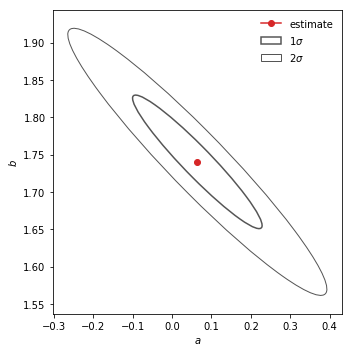

In [85]:
### define X and y, make the first column of X all ones
### so that parameters (a,b) are vectorized
y_err = 0.1
X=np.ones((4,2))
X[:,1] = np.array([1.0,1.5,2.0,2.5])
y = np.array([1.8764,2.5900,3.4979,4.4741])

Cov = y_err**2*np.eye(4)
Cinv = np.linalg.inv(Cov)
Cov_theta = np.linalg.inv(X.T @ Cinv @ X)
theta_best = Cov_theta @ (X.T @ Cinv @ y)

# some tricks to get info we need to plot an ellipse, aligned with 
# the eigenvectors of the covariance matrix
eigval,eigvec = np.linalg.eig(Cov_theta)
angle = np.degrees(np.arctan2(eigvec[1,0], eigvec[0,0]))


w,h = np.sqrt(eigval) * 2 # width and height of ellipse = 2*sigma

fig,ax = plt.subplots(1, 1, figsize=(5,5))

for n in [1,2]:
    ax.add_patch(Ellipse(theta_best, width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=2-n/2, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))
    
ax.plot(*theta_best, marker='o', color='tab:red', zorder=9, label='estimate')

ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.legend(loc='best', frameon=False)
fig.tight_layout()

### Problem 1.2 (2pt)

If our measurements above cannot be repeated (e.g. because the substances that were weighed are not available any more), we can still improve our knowledge of their weight. We don't even need a reference weight! Instead, we can repeatedly measure the reported weight of the empty scale: $y = a + e$. The noise remains as before, $e\sim\mathcal{N}(0,0.1^2)$.

Compute the Fisher matrix of the empty scale problem as a function of the number $N$ of independent measurements, assuming the MLE $\tilde{a}$ from problem 1.1 as fiducial. Combine it with the covariance matrix from 1.1 and determine $N$ so that $\sigma_b=0.05$. Update the plot with the 1- and 2-$\sigma$ uncertainty contours.

**Hint**: The empty scale problem is a zero-th order polynomial regression.

50 0.05269993
52 0.052025024
54 0.0513754
56 0.050749525
58 0.050145976
60 0.049563468
N is 58


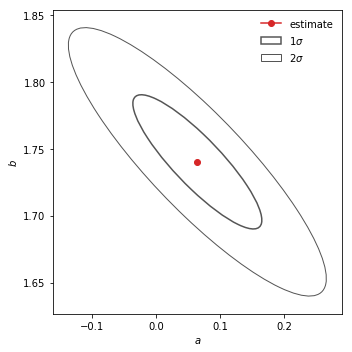

In [111]:
def fisher_matrix(logL, theta_fiducial,N): 
    F = -hessian(logL)(theta_fiducial)
    return N*F

theta_fiducial = theta_best[0]
logL = lambda a: jnp.log(norm.pdf(0,y_err)+a)
 
N_list = np.array([50,52,54,56,58,60])
for N in N_list:
    F_matrix = np.zeros((2,2))
    F_matrix[1,1] = fisher_matrix(logL,theta_fiducial,N)
    F_tot = jnp.linalg.inv(Cov_theta) + F_matrix  #additivity
    cov_tot = jnp.linalg.inv(F_tot)
    sigma_b = jnp.sqrt(cov_tot[1,1])   #marginalization
    print(N, sigma_b)
print(f'N is 58')
    

N = 58
F_matrix = np.zeros((2,2))
F_matrix[1,1] = fisher_matrix(logL,theta_fiducial,N)
F_tot = jnp.linalg.inv(Cov_theta) + F_matrix
cov_tot = jnp.linalg.inv(F_tot)
eigval,eigvec = np.linalg.eig(cov_tot)
angle = np.degrees(np.arctan2(eigvec[1,0], eigvec[0,0]))


w,h = np.sqrt(eigval) * 2 # width and height of ellipse = 2*sigma

fig,ax = plt.subplots(1, 1, figsize=(5,5))

for n in [1,2]:
    ax.add_patch(Ellipse(theta_best, width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=2-n/2, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))
    
ax.plot(*theta_best, marker='o', color='tab:red', zorder=9, label='estimate')

ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.legend(loc='best', frameon=False)

fig.tight_layout()

## Problem 2: Markov Processes (6pts)

Consider the two transition matrices for five-state processes below:

$$
T_{1} \equiv
\begin{pmatrix}
0 & 0 & 0 & 0 & 1\\
0 & \tfrac{1}{2} & 0 & \tfrac{1}{2} & 0\\
0 & 0 & 1 & 0 & 0\\
0 & \tfrac{1}{4} & \tfrac{1}{4} & \tfrac{1}{4} & \tfrac{1}{4}\\
1 & 0 & 0 & 0 & 0
\end{pmatrix}
\ \ \ \mathrm{and} \ \ \
T_{2} \equiv
\begin{pmatrix}
\tfrac{1}{2} & 0 & \tfrac{1}{2} & 0 & 0\\
0 & \tfrac{1}{4} & 0 & \tfrac{3}{4} & 0\\
0 & 0 & \tfrac{1}{3} & 0 & \tfrac{2}{3}\\
\tfrac{1}{4} & \tfrac{1}{2} & 0 & \tfrac{1}{4} & 0\\
\tfrac{1}{3} & 0 & \tfrac{1}{3} & 0 & \tfrac{1}{3}\\
\end{pmatrix}
$$

### Problem 2.1 (1pt): 
Find the communicating classes and determine whether each class is open or closed, and the periodicity of the closed classes.

**Hint:** Make graphs for both processes (but you don't need to include the graphs in this notebook).

Let's denote the five states 1-5. 

For process 1, the communicating classes are C1 = $\{1, 5\}$, C2 = $\{2, 4\}$, C3 = $\{3\}$. C1 and C3 are closed, C2 is open. C1 has period 2 and C3 has period 1 (aperiodic).

For process 2, the communicating classes are C1 = $\{1, 3, 5\}$, C2 = $\{2, 4\}$. C1 is closed and C2 is open. C1 is aperiodic.


In [2]:
%config InlineBackend.figure_format = 'svg'
import daft
pgm = daft.PGM(node_unit=1.5)
pgm.add_node("1", r"$1$", 0, 4, fontsize=12) #plot_params={'lw':2, 'fc':'#eeeeff'})
pgm.add_node("2", r"$2$", 2, 5, fontsize=12)
pgm.add_node("3", r"$3$", 4, 4, fontsize=12)
pgm.add_node("4", r"$4$", 2, 3, fontsize=12)
pgm.add_node("5", r"$5$", 2, 1, fontsize=12)
pgm.add_edge("1", "5")
pgm.add_edge("2", "4")
pgm.add_edge("4", "2")
pgm.add_edge("4", "3")
pgm.add_edge("4", "5")
pgm.add_edge("5", "1")
pgm.show()
pgm = daft.PGM(node_unit=1.5)
pgm.add_node("1", r"$1$", 0, 4, fontsize=12) #plot_params={'lw':2, 'fc':'#eeeeff'})
pgm.add_node("2", r"$2$", 0, 0, fontsize=12)
pgm.add_node("3", r"$3$", 4, 4, fontsize=12)
pgm.add_node("4", r"$4$", 0, 2, fontsize=12)
pgm.add_node("5", r"$5$", 2, 1, fontsize=12)
pgm.add_edge("1", "3")
pgm.add_edge("2", "4")
pgm.add_edge("3", "5")
pgm.add_edge("4", "1")
pgm.add_edge("4", "2")
pgm.add_edge("5", "1")
pgm.add_edge("5", "3")
pgm.show()

<Figure size 389.764x389.764 with 1 Axes>

<Figure size 389.764x389.764 with 1 Axes>

### Problem 2.2 (1pt):

Solve for the stationary distributions of these two processes. Are they unique?

In [2]:
def power_method(A, v, steps=100):
    for step in range(steps):
        v = np.dot(A,v)
        v /= np.linalg.norm(v)
    return v
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

### process 1
T1 = np.matrix([
    [0,0,0,0,1],
    [0,1/2,0,1/2,0],
    [0,0,1,0,0],
    [0,1/4,1/4,1/4,1/4],
    [1,0,0,0,0]])

v = np.random.rand(T1.shape[0]).reshape((-1,1))
v = power_method(T1.T, v)
v /= v.sum()
res = v.flatten()
print(f'stationary distribution for process 1 is: {res}')

### process 2
T2 = np.matrix([
    [1/2,0,1/2,0,0],
    [0,1/4,0,3/4,0],
    [0,0,1/3,0,2/3],
    [1/4,1/2,0,1/4,0],
    [1/3,0,1/3,0,1/3]])

v = np.random.rand(T2.shape[0]).reshape((-1,1))
v = power_method(T2.T, v)
v /= v.sum()
res = v.flatten()
print(f'stationary distribution for process 2 is: {res}')
print('Stationary distribution for process 1 is not unique because it has more than one closed communicating class.')
print('Stationary distribution for process 2 is unique.')

stationary distribution for process 1 is: [[0.452 0.000 0.283 0.000 0.265]]
stationary distribution for process 2 is: [[0.250 0.000 0.375 0.000 0.375]]
Stationary distribution for process 1 is not unique because it has more than one closed communicating class.
Stationary distribution for process 2 is unique.


### Problem 2.3 (3pts):


Mutation in gene sequences arise naturally, however, there are regions in the genome with low variability (probably because they encode something important for the organism) and regions with high variability. We will infer the transition probability of nucleotides from a mitochondrial DNA sequence from the human [hypervariable region I](https://en.wikipedia.org/wiki/Hypervariable_region). It's a regions that can be used to geographically locate members of a population. 

*Details (if you are curious):
The data were drawn from all available samples in [GenBank](https://www.ncbi.nlm.nih.gov/nuccore/?term=(hvrI)+AND+%22Homo+sapiens%22%5Bporgn%3A__txid9606%5D) and comprise 1454 different individuals' gene sequences, each typically 400 base pairs long. The sequences were then aligned with [Clustal Omega](https://www.ebi.ac.uk/Tools/msa/clustalo/).*

The file `aln-vienna.txt` is a simple text file. Lines that start with `>` contain a comment string that describes the original sample. They should be removed from further analysis.
The remaining lines are DNA sequences of individuals, and aligned to a consensus sequence, which means all sequences have the same length.
They comprise the letters `ACGT` for the nucleotides or the symbol `-`, which stands for an insert where the particular sequence does not have a nucleotide that is present in the aligned consensus sequence.

Compute the proportion of changes $p^{(12)}$ for any pair of sequences in the data set. Adopt the Jukes-Cantor model of DNA evolution and estimate the time $t$ over which any two sequences started to evolve separately from a common ancestor. Use the MLE of the Jukes-Cantor mutation rate $\mu$ and an assumed average mutation rate of $r=0.5$ per nucleotide site per million years, obtained from other studies for the human HVRI. Make a histogram of the evolution time distribution for two individuals (sample numbers 20 and 500). 

**Hints**:

* Open the file with
```
data = np.genfromtxt('aln-vienna.txt', comments='>', dtype=np.unicode_)
data = np.array([list(line) for line in data])
```
* Don't forget axis labels for your plot.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


Text(0, 0.5, 'counts')

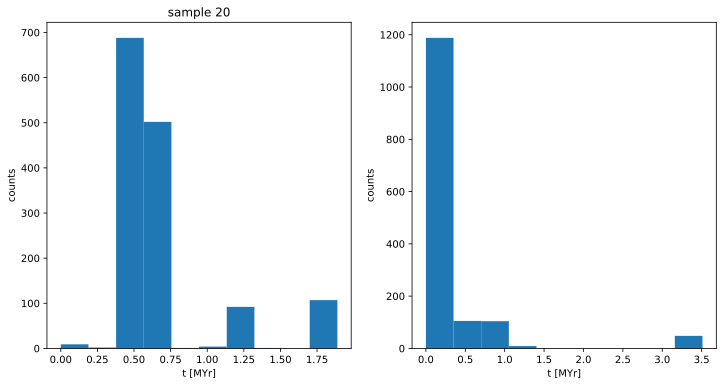

In [4]:
r = 0.5
data = np.genfromtxt('aln-vienna.txt', comments='>', dtype=np.unicode_)
data = np.array([list(line) for line in data])
num_person, seq_len = data.shape
t20, t500 = [], []

### since python start couting from 0
### sample 20 and 500 correspond to data[19] and data[499]
for i in range(0, num_person):
    p20 = len(np.argwhere(data[i] != data[19]))/seq_len
    p500 = len(np.argwhere(data[i] != data[499]))/seq_len
    t20.append(-1/r * np.log(1- 4/3 * p20))
    t500.append(-1/r * np.log(1- 4/3 * p500))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(t20)
axs[1].hist(t500)
axs[0].set_title(r'sample 20')
axs[0].set_xlabel(r't [MYr]')
axs[0].set_ylabel(r'counts')
axs[1].set_title(r'sample 500')
axs[1].set_xlabel(r't [MYr]')
axs[1].set_ylabel(r'counts')

### Problem 2.4 (1pt):

The Jukes-Cantor model is simplistic, but the distance and time estimates we derive from it even more so. One aspect it does not cover is the possibility of a mutation happening at some site, followed by another one that changes the nucleotide back to its original state. Looking only at the proportion of changes thus underestimates the true mutation rate.

Determine the probability of this two-step mutation process for $p^{(12)}=\tfrac{1}{10}$ for some time t, assuming that each of the mutations had the time $t/2$ to occur.

In [8]:
tmu = - np.log(1- 4/3/10)
P = 3 * pow(1/4 - 1/4 * np.exp(-tmu/2), 2)
print(f'Probability of two-step mutation for a given nucleotide is: {P}')

Probability of two-step mutation for a given nucleotide is: 0.0008939989057764706
